In [1]:
from utils import get_hyperedges, get_data, get_H, check_feasibility
from model import CustomLossBatch, utility_fn
from datagen import generate_data
from linsat import linsat_layer_modified
import torch
import time
import numpy as np
import pickle

# Pyomo Solver

In [2]:
# from pyomo.environ import (
#     ConcreteModel, Var, Objective, ConstraintList, SolverFactory, NonNegativeReals, Binary, maximize
# )
# # Step 2: Create Pyomo model
# model = ConcreteModel()

# # Step 3: Define binary decision variables for each link (b_i)
# model.b = Var(range(V_H), domain=Binary)  # b[i] = 1 if link i is active, 0 otherwise

# # Step 4: Define the objective function (maximize throughput)
# def throughput(model):
#     total_throughput = 0
#     for i in range(V_H):
#         interference = sum(model.b[j] * I[i, j] for j in range(V_H) if j != i)  # Interference from other active links
#         denominator = N[i] + interference  # Noise + interference
#         total_throughput += (I[i,i] * model.b[i]) / denominator  # Contribution of link i to throughput
#     return total_throughput

# model.obj = Objective(rule=throughput, sense=maximize)

# # Step 5: Add constraints for hyperedges (each hyperedge has a threshold)
# model.constraints = ConstraintList()

# for e_idx, hyperedge in enumerate(hyperedges):
#     model.constraints.add(
#         sum(model.b[i] for i in hyperedge) <= len(hyperedge)-1
#     )

# # Step 6: Solve the model
# solver = SolverFactory('ipopt')  # Use Ipopt for nonlinear problems
# result = solver.solve(model, tee=True)

# # Step 7: Extract the results
# optimal_decisions = [model.b[i].value for i in range(V_H)]

# # Output the optimal link schedule
# print("Optimal link schedule:", optimal_decisions)
# print("Maximum throughput:", model.obj())

## HyperDataset

**Run this before Loading Saved Data**

In [2]:
from torch.utils.data import Dataset, DataLoader

class HyperDataset(Dataset):
    def __init__(self, I, Dv_inv, De_inv, H, W):
        self.I = I
        self.Dv_inv = Dv_inv
        self.De_inv = De_inv
        self.H = H
        self.W = W

    def __len__(self):
        return len(self.I)

    def __getitem__(self, idx):
        return self.I[idx], self.Dv_inv[idx], self.De_inv[idx], self.H[idx], self.W[idx]


# Parameters

In [4]:

# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
# N = 0.1  # Noise power
N_db = -136.87  # dB
N = 10**(N_db/10)
theta = 0.5  # Thresholds for hyperedges
k = 4  # max hyperedge cardinality
train_samples = 10000
test_samples = 100
batch_size = 100

# Load Pre-Generated Data

**Use this data for result evaluation**</br>
<span style="color:cyan">**Skip Generate Data and Data Prepration If you are using this part**</span>

In [6]:
with open('train_dataset_n10.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('test_dataset_n10.pkl', 'rb') as f:
    test_dataset = pickle.load(f)


# defining a data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate data

In [3]:
itens_train, hlist_train = get_data(train_samples, V_H, N, theta, k)
itens_test, hlist_test = get_data(test_samples, V_H, N, theta, k)
H_train = get_H(hlist_train, V_H, train_samples)
H_test = get_H(hlist_test, V_H, test_samples)

# Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [7]:
def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    

    hypergraph["I"] = torch.DoubleTensor(I)


    H = torch.DoubleTensor(hyperedges)
    Dv_inv = torch.diag(H.sum(0)**(-1/2))
    De_inv = torch.diag(H.sum(1)**(-1))
    W = torch.eye(V_H, dtype=torch.float64)
    hypergraph["H"] = H
    hypergraph["Dv_inv"] = Dv_inv
    hypergraph["De_inv"] = De_inv
    hypergraph["W"] = W
    return hypergraph

### Generating train and test dataste

In [ ]:
hyps_train, hyps_test = [], []

Is = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_train), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_train, H_train):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

train_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)

Is = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Dv_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
De_invs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Hs = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)
Ws = torch.zeros((len(itens_test), V_H, V_H), dtype=torch.float64)

i = 0
for I, hyperedges in zip(itens_test, H_test):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    Is[i] = hyp["I"]
    Dv_invs[i] = hyp["Dv_inv"]
    De_invs[i] = hyp["De_inv"]
    Hs[i] = hyp["H"]
    Ws[i] = hyp["W"]
    i += 1

test_dataset = HyperDataset(Is, Dv_invs, De_invs, Hs, Ws)


# defining a data loader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

# Exhaustive Search Solver

In [7]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None
    for i in range(2**V_H):
        schedule = torch.FloatTensor([int(x) for x in bin(i)[2:].zfill(V_H)])
        throughput = 0

        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            non_zero_idx = torch.nonzero(hyperedge).squeeze(0)
            if sum(schedule[non_zero_idx]) == len(non_zero_idx):
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue
        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += np.log2(1+(I[i,i] * schedule[i]) / denominator)
        
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [9]:
best_throughput_test = []
for sample in test_dataset:
    X, _, _, H, _ = sample
    best_throughput, best_schedule = exh_solver(X.shape[0], X.shape[0], X.shape[0]*[N], X, H)
    best_throughput_test.append(best_throughput)
    print("Exhaustive search results:")
    print("Optimal link schedule:", best_schedule)
    print("Maximum throughput:", best_throughput, "bits/s/Hz")
tput_optimal_mean = np.mean(best_throughput_test)
print(f"Mean average throughput: {tput_optimal_mean}")

Exhaustive search results:
Optimal link schedule: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Maximum throughput: tensor(32.7847, dtype=torch.float64) bits/s/Hz
Exhaustive search results:
Optimal link schedule: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Maximum throughput: tensor(34.6757, dtype=torch.float64) bits/s/Hz
Exhaustive search results:
Optimal link schedule: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Maximum throughput: tensor(33.5847, dtype=torch.float64) bits/s/Hz
Exhaustive search results:
Optimal link schedule: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Maximum throughput: tensor(33.9763, dtype=torch.float64) bits/s/Hz
Exhaustive search results:
Optimal link schedule: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Maximum throughput: tensor(33.8029, dtype=torch.float64) bits/s/Hz
Exhaustive search results:
Optimal link schedule: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Maximum throughput: tensor(37.0554, dtype=torch.float64) bits/s/Hz
Exha

# Learning-Based

In [10]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training HGNN

In [11]:
def get_learnable_parameters(V_H, device):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

In [12]:
def HGNN(X, Dv_inv, De_inv, H, W, theta, batch_norm=False):
    theta_1, theta_2, theta_3 = theta
    Xbar1 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X @ theta_1.unsqueeze(0)
    X1 = torch.nn.functional.relu(Xbar1)
    if batch_norm:
        X1 = (X1 - torch.mean(X1, dim=0))/torch.sqrt(torch.var(X1, dim=0) + 1e-5)
    Xbar2 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X1 @ theta_2.unsqueeze(0)
    X2 = torch.nn.functional.relu(Xbar2)
    if batch_norm:
        X2 = (X2 - torch.mean(X2, dim=0))/torch.sqrt(torch.var(X2, dim=0) + 1e-5)
    Xbar3 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X2 @ theta_3.unsqueeze(0)
    X3 = torch.nn.functional.sigmoid(Xbar3)
    X3 = X3.squeeze()
    return X3

# Training

In [46]:
theta_HGNN = get_learnable_parameters(V_H, device)
optimizer = torch.optim.Adam(theta_HGNN, lr=0.01)
# optimizer = torch.optim.SGD(theta_HGNN, lr=0.01)

loss_fn = CustomLossBatch()

In [47]:
beta = 1
tau = 1
max_iter = 1000
epochs = 1000
batch_norm=True
train_utility, test_utility = [], []
loss_train, loss_test = [], []

# store the initial utilities without training
with torch.no_grad():
    utility_epoch = []
    loss_train_epoch = []
    for (X, Dv_inv, De_inv, H, W) in train_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
        # Linsat
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)
        utility_epoch.append(utility.item()/batch_size)
        loss_train_epoch.append(loss.item()/batch_size)
    utility_epoch_mean = np.mean(utility_epoch)
    train_utility.append(utility_epoch_mean)
    loss_train.append(np.mean(loss_train_epoch))
    print(f"Initial utility per hypergraph in Training: {train_utility[-1]}")

    # test
    utility_epoch_test = []
    loss_test_epoch = []
    for (X, Dv_inv, De_inv, H, W) in test_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
        # Linsat 
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        utility_epoch_test.append(utility.item()/batch_size)
        loss_test_epoch.append(loss.item()/batch_size)
    utility_epoch_test_mean = np.mean(utility_epoch_test)
    test_utility.append(utility_epoch_test_mean)
    loss_test.append(np.mean(loss_test_epoch))
    print(f"Initial utility per hypergraph in Testing: {test_utility[-1]}")
        




optimizer.zero_grad()
for epoch in range(epochs):
    # Train Phase
    loss_epoch, utility_epoch, feasibility_epoch = [], [], []
    for (X, Dv_inv, De_inv, H, W) in train_loader:
        X, H, W = X.to(device), H.to(device), W.to(device)
        Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
        # Linsat
        z = z * beta
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
        z = z / beta
        loss = loss_fn(z, X, N, gamma=0.0)[0]
        utility = utility_fn(z, X, N)  # utility based on discrete values of z
        feasibility = check_feasibility(H, z)
        utility_epoch.append(utility.item()/batch_size)
        feasibility_epoch.append(feasibility)
        loss.backward()
        # print(torch.linalg.matrix_norm(theta_HGNN[0].grad))
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch.append(loss.item()/batch_size)
    # Test Phase
    loss_epoch_test, utility_epoch_test, feasibility_epoch_test = [], [], []
    with torch.no_grad():
        for (X, Dv_inv, De_inv, H, W) in test_loader:
            X, H, W = X.to(device), H.to(device), W.to(device)
            Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)
            z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
            # Linsat 
            z = z * beta
            RHS_const = H.transpose(2, 1).sum(dim=2) - 1
            LHS_const = H.transpose(2, 1)
            z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
            z = z / beta
            loss = loss_fn(z, X, N, gamma=0.0)[0]
            utility = utility_fn(z, X, N)  # utility based on discrete values of z
            feasibility = check_feasibility(H, z)
            utility_epoch_test.append(utility.item()/batch_size)
            feasibility_epoch_test.append(feasibility)
            loss_epoch_test.append(loss.item()/batch_size)
    utility_epoch_mean = np.mean(utility_epoch)
    utility_epoch_test_mean = np.mean(utility_epoch_test)
    feasibility_epoch_mean = np.mean(feasibility_epoch)
    feasibility_epoch_test_mean = np.mean(feasibility_epoch_test)
    loss_epoch_mean = np.mean(loss_epoch)
    loss_test_mean = np.mean(loss_epoch_test)
    
    print(z[0])
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss:{np.mean(loss_epoch):.5f} | Train Utility: {utility_epoch_mean:.5f}, Feasibility: {feasibility_epoch_mean:.2f}" \
        f" | Test Utility: {utility_epoch_test_mean:.5f}, Feasibility: {feasibility_epoch_test_mean:.2f}")
    train_utility.append(utility_epoch_mean)
    test_utility.append(utility_epoch_test_mean)
    loss_train.append(loss_epoch_mean)
    loss_test.append(loss_test_mean)
print(f"Final utility per hypergraph: {utility_epoch_test}")

Initial utility per hypergraph in Training: 9.023827883211249
Initial utility per hypergraph in Testing: 7.846885677651727
tensor([0.3521, 0.3351, 0.3465, 0.3933, 0.3935, 0.3179, 0.2429, 0.3465, 0.3452,
        0.5486], dtype=torch.float64)
Epoch: 0, Loss:-13.09598 | Train Utility: 10.27143, Feasibility: 1.00 | Test Utility: 8.48233, Feasibility: 1.00
tensor([0.3374, 0.2878, 0.3467, 0.3801, 0.3683, 0.2979, 0.2634, 0.3467, 0.3617,
        0.5254], dtype=torch.float64)
Epoch: 1, Loss:-13.12057 | Train Utility: 11.50974, Feasibility: 1.00 | Test Utility: 7.97809, Feasibility: 1.00
tensor([0.3518, 0.2906, 0.3468, 0.3803, 0.3683, 0.2928, 0.2635, 0.3468, 0.3571,
        0.5258], dtype=torch.float64)
Epoch: 2, Loss:-13.12085 | Train Utility: 11.78972, Feasibility: 1.00 | Test Utility: 8.23425, Feasibility: 1.00
tensor([0.3489, 0.2909, 0.3468, 0.3802, 0.3683, 0.2936, 0.2634, 0.3468, 0.3554,
        0.5256], dtype=torch.float64)
Epoch: 3, Loss:-13.12278 | Train Utility: 11.68748, Feasibility: 1

KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt

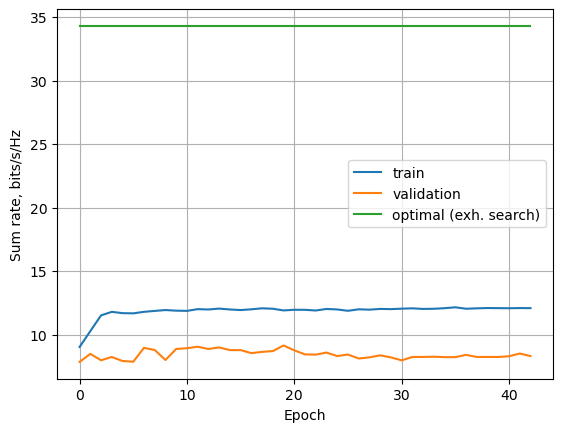

In [49]:
plt.plot(train_utility, label='train')
plt.plot(test_utility, label='validation')
plt.plot(np.full_like(train_utility, tput_optimal_mean), label='optimal (exh. search)')
plt.xlabel('Epoch')
plt.ylabel('Sum rate, bits/s/Hz')
plt.grid()
plt.legend()
plt.savefig('HGNN_train.jpg')

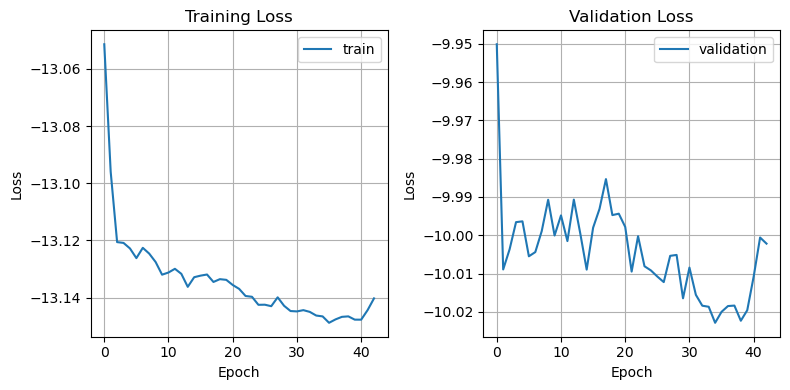

In [52]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot loss_train
axs[0].plot(loss_train, label='train')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot loss_test
axs[1].plot(loss_test, label='validation')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# Greedy Extension

In [53]:
from greedy_solvers import gready_scheduler


# without utility function
utility_test_wo_utility = []
utility_test_w_utility = []
utility_test_base_utility = []
exhaustive_utility = []
for (X, Dv_inv, De_inv, H, W) in test_loader:
    X, H, W = X.to(device), H.to(device), W.to(device)
    Dv_inv, De_inv = Dv_inv.to(device), De_inv.to(device)

    # exhaustive search
    ex_ut = 0
    for i in range(X.shape[0]):
        best_throughput, best_schedule = exh_solver(X.shape[1], X.shape[1], V_H*[N], X[i], H[i])
        ex_ut += best_throughput
    
    

    # learning based utility
    z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, batch_norm)
    # Linsat 
    z = z * beta
    RHS_const = H.transpose(2, 1).sum(dim=2) - 1
    LHS_const = H.transpose(2, 1)
    z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=tau, max_iter=max_iter, dummy_val=0, no_warning=False, grouped=False).double()
    z = z / beta

    # base utility
    # round z to the nearest integer
    zd = torch.round(z)
    utility_base = utility_fn(zd, X, N)

    # wo utility
    zwo = gready_scheduler(z, X, H, N, False)
    utility_wo = utility_fn(zwo, X, N)

    # w utility
    zw = gready_scheduler(z, X, H, N, True)
    utility_w = utility_fn(zw, X, N)


     # utility based on discrete values of z
    utility_test_base_utility.append(utility_base.item())
    utility_test_wo_utility.append(utility_wo.item())
    utility_test_w_utility.append(utility_w.item())
    exhaustive_utility.append(ex_ut)
    #feasibility_epoch_test.append(feasibility)

utility_base = np.sum(utility_test_base_utility)/(len(test_loader)*batch_size)
utility_test_wo_mean = np.sum(utility_test_wo_utility)/(len(test_loader)*batch_size)
utility_test_w_mean = np.sum(utility_test_w_utility)/(len(test_loader)*batch_size)
exhaustive_utility_mean = np.sum(exhaustive_utility)/(len(test_loader)*batch_size)



In [54]:
print(f"Utility without utility function: {utility_test_wo_mean}")
print(f"Utility with utility function: {utility_test_w_mean}")
print(f"Utility base: {utility_base}")
print(f"Utility exhaustive search: {exhaustive_utility_mean}")

Utility without utility function: 8.622852519827088
Utility with utility function: 26.543487547180263
Utility base: 8.45664749108489
Utility exhaustive search: 26.798917966834217


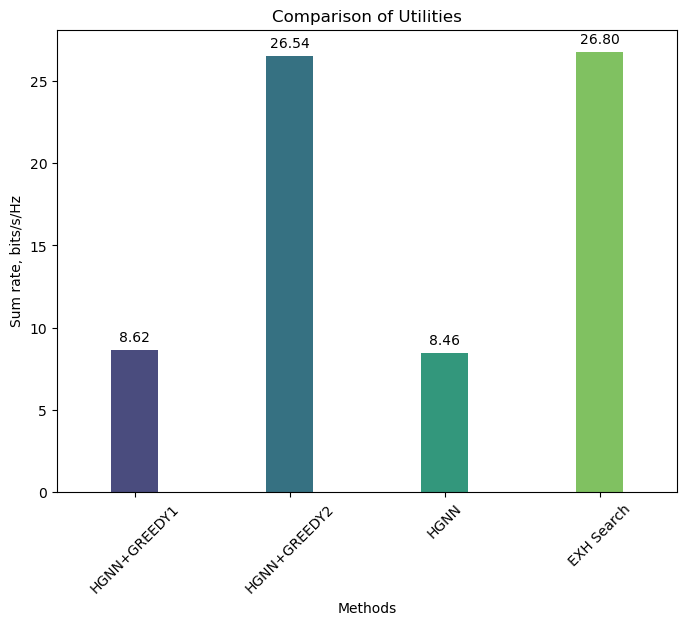

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
utilities = {
    "HGNN+GREEDY1": utility_test_wo_mean,
    "HGNN+GREEDY2": utility_test_w_mean,
    "HGNN": utility_base,
    "EXH Search": exhaustive_utility_mean
}

# Create a DataFrame for seaborn
df_utilities = pd.DataFrame(list(utilities.items()), columns=['Type', 'Value'])

# Plotting with smaller size and numbers on top
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Type', y='Value', data=df_utilities, palette='viridis', width=0.3)
plt.title('Comparison of Utilities')
plt.xlabel('Methods')
plt.ylabel('Sum rate, bits/s/Hz')
plt.xticks(rotation=45)
plt.grid(False)

# Adding the values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.show()